# 第5回_Beginner限定コンペ】アメリカの都市エイムズの住宅価格予測
## 住居や周辺環境に関する情報などを元に住宅の価格を予測しよう！

### データの説明
train : モデル評価用データ  
test  : 予測のためのデータ



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import category_encoders as ce
%matplotlib inline

from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score, StratifiedShuffleSplit, ShuffleSplit
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

pd.set_option('display.max_columns', 100)


In [5]:
df_master_train = pd.read_csv('train.csv')
df_master_train

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,200,2163,20,RL,9000,Reg,Lvl,Inside,NAmes,1Fam,1Story,5,5,1963,1950,Gable,VinylSd,VinylSd,TA,CBlock,554.725259,490.862838,620.339061,Ex,Y,SBrkr,941,0,2358,1.001999,2,0,3,1,TA,5,0,1.998003,381.014258,Y,0,0,7,2007,WD,Normal,158000
1,3832,1862,20,RL,9600,Reg,Lvl,Inside,CollgCr,1Fam,1Story,7,5,2006,2006,Gable,VinylSd,VinylSd,Gd,PConc,514.217911,1711.943709,1286.011022,Ex,Y,SBrkr,894,0,1040,0.002000,2,0,3,1,Gd,6,0,1.998003,384.114652,Y,0,0,11,2007,WD,Normal,145000
2,4927,754,20,RL,9600,Reg,Lvl,Inside,NridgHt,1Fam,1Story,9,5,2007,2007,Hip,VinylSd,VinylSd,Gd,PConc,1596.991227,511.217197,1341.741207,Ex,Y,SBrkr,864,0,864,1.001999,2,0,3,1,Gd,7,1,2.998015,625.140330,Y,0,0,5,2008,WD,Normal,125000
3,4088,641,80,RL,9600,Reg,Lvl,Inside,OldTown,1Fam,SLvl,6,6,1976,1950,Gable,VinylSd,Plywood,TA,CBlock,586.182353,469.685845,566.069609,Gd,Y,SBrkr,864,0,864,0.002000,1,0,3,1,TA,6,0,0.998002,193.156275,Y,0,0,7,2006,WD,Normal,135000
4,3644,754,20,RL,9600,Reg,Lvl,Inside,NoRidge,1Fam,1Story,7,5,1994,2002,Gable,VinylSd,VinylSd,Gd,PConc,1589.946047,484.337352,1258.013116,Ex,Y,SBrkr,832,0,1040,1.001998,2,0,3,1,Gd,7,1,2.998012,617.903766,Y,0,0,7,2007,WD,Normal,175000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4931,27,120,RL,1680,Reg,Lvl,Inside,NridgHt,TwnhsE,1Story,5,5,2004,2004,Gable,VinylSd,VinylSd,TA,PConc,620.110745,511.080630,1163.794125,Ex,Y,SBrkr,1337,0,1728,0.002000,2,0,3,1,TA,6,0,1.998001,416.886419,Y,0,0,5,2009,WD,Normal,130000
2996,3264,2203,160,RL,2665,Reg,Lvl,Inside,MeadowV,1Fam,2Story,5,5,1970,1970,Gable,CemntBd,MetalSd,TA,PConc,0.001057,480.872842,543.789909,Ex,Y,SBrkr,1040,0,1040,0.001999,1,1,3,1,TA,6,0,1.998004,371.721904,Y,0,0,5,2006,WD,Normal,140000
2997,1653,2447,20,RL,7200,Reg,Lvl,Inside,NAmes,1Fam,1Story,5,5,1963,1950,Gable,VinylSd,VinylSd,TA,CBlock,554.523591,488.283374,621.223013,Ex,Y,SBrkr,1098,0,2358,1.001999,2,0,3,1,TA,5,0,1.998003,379.306321,Y,0,0,7,2007,WD,Normal,158000
2998,2607,378,60,FV,9000,Reg,Lvl,Inside,Somerst,1Fam,2Story,6,5,2005,1950,Gable,VinylSd,VinylSd,Gd,PConc,0.000872,504.687298,599.525621,Ex,Y,SBrkr,728,0,1456,0.001999,2,1,3,1,TA,7,1,1.998002,371.138581,Y,0,0,7,2007,WD,Normal,158000


In [6]:
df_master_train.isnull().sum()

index             0
Order             0
MS SubClass       0
MS Zoning         0
Lot Area          0
Lot Shape         0
Land Contour      0
Lot Config        0
Neighborhood      0
Bldg Type         0
House Style       0
Overall Qual      0
Overall Cond      0
Year Built        0
Year Remod/Add    0
Roof Style        0
Exterior 1st      0
Exterior 2nd      0
Exter Qual        0
Foundation        0
BsmtFin SF 1      0
Bsmt Unf SF       0
Total Bsmt SF     0
Heating QC        0
Central Air       0
Electrical        0
1st Flr SF        0
2nd Flr SF        0
Gr Liv Area       0
Bsmt Full Bath    0
Full Bath         0
Half Bath         0
Bedroom AbvGr     0
Kitchen AbvGr     0
Kitchen Qual      0
TotRms AbvGrd     0
Fireplaces        0
Garage Cars       0
Garage Area       0
Paved Drive       0
Wood Deck SF      0
Open Porch SF     0
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
dtype: int64

In [7]:
df_master_test = pd.read_csv('test.csv')
df_master_test

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,398,414,60,RL,6120,IR1,Lvl,Inside,CollgCr,1Fam,2Story,8,5,1994,1950,Gable,VinylSd,VinylSd,TA,PConc,505.055258,197.338260,616.126989,Ex,Y,SBrkr,864,0,864,0.002000,2,0,3,1,Gd,7,1,2.998003,372.666174,Y,0,0,6,2006,WD,Normal
1,3833,2163,20,RL,9600,Reg,Lvl,Inside,Sawyer,1Fam,1Story,5,5,2008,1962,Gable,VinylSd,VinylSd,TA,PConc,1624.953706,494.176016,1285.118653,Ex,Y,SBrkr,1382,0,864,1.001999,2,0,3,1,TA,5,0,1.998014,637.974154,Y,0,0,3,2006,WD,Normal
2,4836,754,20,RL,9600,IR1,Lvl,Inside,NridgHt,1Fam,1Story,9,5,2006,1950,Gable,VinylSd,VinylSd,TA,PConc,0.001088,1813.402938,1294.560167,Ex,Y,SBrkr,912,0,864,0.002000,2,0,3,1,Ex,10,1,2.998008,605.913790,Y,0,0,5,2007,WD,Normal
3,4572,2284,80,RL,9600,IR1,Lvl,Inside,NAmes,1Fam,SLvl,5,5,1978,1950,Gable,Plywood,Plywood,TA,CBlock,567.457470,202.103285,598.983455,TA,Y,SBrkr,864,0,864,1.001999,1,0,3,1,TA,6,1,0.998020,200.755592,Y,0,0,7,2006,WD,Normal
4,636,2163,20,RL,7200,Reg,Lvl,Inside,NAmes,1Fam,1Story,5,5,1963,1950,Gable,VinylSd,VinylSd,TA,CBlock,555.696962,489.267758,622.300052,Ex,Y,SBrkr,941,0,848,1.001999,2,0,3,1,TA,5,0,1.998003,377.495159,Y,0,0,7,2007,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3138,2447,120,RL,3907,IR1,Lvl,Inside,StoneBr,1Fam,1Story,8,5,2006,2002,Gable,VinylSd,CmentBd,Gd,PConc,562.267832,526.636360,1242.211251,Ex,Y,SBrkr,1337,0,1728,0.002000,2,0,3,1,Gd,8,1,1.998003,641.261977,Y,0,0,6,2007,WD,Normal
1996,191,27,120,RL,3907,IR1,Lvl,Inside,Mitchel,1Fam,1Story,6,5,2006,2007,Gable,HdBoard,CmentBd,Gd,PConc,1566.140763,214.618116,1269.312702,TA,Y,SBrkr,1646,0,1728,1.001999,1,0,2,1,Gd,4,1,1.998007,387.032024,Y,0,0,7,2008,WD,Normal
1997,3294,208,50,RL,6000,Reg,Lvl,Inside,Crawfor,1Fam,1.5Fin,4,6,1993,1950,Gable,MetalSd,MetalSd,TA,CBlock,540.277638,473.226887,591.167928,Ex,Y,SBrkr,864,0,864,0.001999,2,0,3,1,TA,6,0,1.998007,406.608942,Y,0,0,7,2009,WD,Normal
1998,3073,1293,120,RL,1680,Reg,Lvl,Inside,Edwards,1Fam,1Story,5,5,1976,2006,Gable,VinylSd,VinylSd,TA,PConc,0.001131,1121.285286,616.777786,TA,Y,SBrkr,1337,0,1728,0.002000,1,0,3,1,TA,5,1,-0.001999,-0.001395,Y,0,0,6,2009,WD,Normal


In [8]:
df_master_test.isnull().sum()

index             0
Order             0
MS SubClass       0
MS Zoning         0
Lot Area          0
Lot Shape         0
Land Contour      0
Lot Config        0
Neighborhood      0
Bldg Type         0
House Style       0
Overall Qual      0
Overall Cond      0
Year Built        0
Year Remod/Add    0
Roof Style        0
Exterior 1st      0
Exterior 2nd      0
Exter Qual        0
Foundation        0
BsmtFin SF 1      0
Bsmt Unf SF       0
Total Bsmt SF     0
Heating QC        0
Central Air       0
Electrical        0
1st Flr SF        0
2nd Flr SF        0
Gr Liv Area       0
Bsmt Full Bath    0
Full Bath         0
Half Bath         0
Bedroom AbvGr     0
Kitchen AbvGr     0
Kitchen Qual      0
TotRms AbvGrd     0
Fireplaces        0
Garage Cars       0
Garage Area       0
Paved Drive       0
Wood Deck SF      0
Open Porch SF     0
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
dtype: int64

## 前処理

train testをマージする。trainにしかないSalePriceはdrop

In [9]:
# マスターtrainデータから目的変数と説明変数を分けて格納
master_train_x = df_master_train.drop('SalePrice',axis = 1)
master_train_y = df_master_train['SalePrice']

# testデータの取得（上でコネコネしてるのでリセット）
test_x = df_master_test.copy()

# 学習データとテストデータを結合
all_data = pd.concat([master_train_x, test_x],axis = 0)


# indexは使わないので格納　Orderは使うver
master_train_index = df_master_train['index']
test_index  = df_master_test['index']


# index を削除
all_data.drop('index',axis = 1,inplace = True)

print('all_data',all_data.shape)
print('master_train_x',master_train_x.shape)
print('master_train_y',master_train_y.shape)
print('test_x',test_x.shape)


all_data (5000, 45)
master_train_x (3000, 46)
master_train_y (3000,)
test_x (2000, 46)


In [10]:
test_x.head(3)

,index,Order,MS SubClass,MS Zoning,Lot Area,Lot Shape,Land Contour,Lot Config,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Exterior 1st,Exterior 2nd,Exter Qual,Foundation,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,398,414,60,RL,6120,IR1,Lvl,Inside,CollgCr,1Fam,2Story,8,5,1994,1950,Gable,VinylSd,VinylSd,TA,PConc,505.055258,197.338260,616.126989,Ex,Y,SBrkr,864,0,864,0.002000,2,0,3,1,Gd,7,1,2.998003,372.666174,Y,0,0,6,2006,WD,Normal
1,3833,2163,20,RL,9600,Reg,Lvl,Inside,Sawyer,1Fam,1Story,5,5,2008,1962,Gable,VinylSd,VinylSd,TA,PConc,1624.953706,494.176016,1285.118653,Ex,Y,SBrkr,1382,0,864,1.001999,2,0,3,1,TA,5,0,1.998014,637.974154,Y,0,0,3,2006,WD,Normal
2,4836,754,20,RL,9600,IR1,Lvl,Inside,NridgHt,1Fam,1Story,9,5,2006,1950,Gable,VinylSd,VinylSd,TA,PConc,0.001088,1813.402938,1294.560167,Ex,Y,SBrkr,912,0,864,0.002000,2,0,3,1,Ex,10,1,2.998008,605.913790,Y,0,0,5,2007,WD,Normal


## カラム名に空白が入っているものをunderlineに置き換える
light_gbm実行時に警告文が出るため、回避策

In [11]:
for i in range(len(all_data.columns)):
    under_score_name = all_data.columns[i].replace(' ','_')
    all_data.rename(columns = {all_data.columns[i] : under_score_name}, inplace = True)

In [12]:
all_data.columns,print('\nカラム数：',len(all_data.columns))


カラム数： 45


(Index(['Order', 'MS_SubClass', 'MS_Zoning', 'Lot_Area', 'Lot_Shape',
        'Land_Contour', 'Lot_Config', 'Neighborhood', 'Bldg_Type',
        'House_Style', 'Overall_Qual', 'Overall_Cond', 'Year_Built',
        'Year_Remod/Add', 'Roof_Style', 'Exterior_1st', 'Exterior_2nd',
        'Exter_Qual', 'Foundation', 'BsmtFin_SF_1', 'Bsmt_Unf_SF',
        'Total_Bsmt_SF', 'Heating_QC', 'Central_Air', 'Electrical',
        '1st_Flr_SF', '2nd_Flr_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
        'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr',
        'Kitchen_Qual', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Cars',
        'Garage_Area', 'Paved_Drive', 'Wood_Deck_SF', 'Open_Porch_SF',
        'Mo_Sold', 'Yr_Sold', 'Sale_Type', 'Sale_Condition'],
       dtype='object'),
 None)

### カテゴリ変数の処理

In [13]:
# dtypeがobject（カテゴリ変数）のカラムを抽出
object_index_list = list(all_data.dtypes.loc[all_data.dtypes == 'object'].index)
value_index_list = list(all_data.dtypes.loc[all_data.dtypes != 'object'].index)

# intになっているけどカテゴリ変数なものを主導でピックアップ
'''memo
・
・○○Grはグレードを数字で表しているっぽい？　のでカテゴリ
・Full_Bath、Half_Bathがなんだかわからん。。風呂の数？ カテゴリじゃないと仮定
'''
#pickup_category_index = ['MS_SubClass',
#                         'Overall_Qual',
#                         'Overall_Cond',
#                         'Bedroom_AbvGr',
#                         'Kitchen_AbvGr',
#                         'TotRms_AbvGrd']
# object_index_listに追加↑を追加
#for i in pickup_category_index:
#    object_index_list.append(i)

object_index_list

['MS_Zoning',
 'Lot_Shape',
 'Land_Contour',
 'Lot_Config',
 'Neighborhood',
 'Bldg_Type',
 'House_Style',
 'Roof_Style',
 'Exterior_1st',
 'Exterior_2nd',
 'Exter_Qual',
 'Foundation',
 'Heating_QC',
 'Central_Air',
 'Electrical',
 'Kitchen_Qual',
 'Paved_Drive',
 'Sale_Type',
 'Sale_Condition']

  
  
memo
Mo_sold : 売られた月。　日付データは何かしら処理したほうがよさそう。一旦ここでは据え置き



In [14]:
# memo カテゴリか微妙なやつをチェック
for i in range(len(value_index_list)):
    print('\nindex_name:\n',value_index_list[i])
    print('\nunique:\n',all_data[value_index_list[i]].unique())
    print('\nlengs:\n',len(all_data[value_index_list[i]].unique()))


index_name:
 Order

unique:
 [2163 1862  754  641  126 1464 2603 2902 2284 2447   27  786  326  378
  350 1293 2203  839   70 1027 1499   99  208 2659 1482  203 2191  632
 1056 1879 2873  610 2043 2784 1220   44 2632  568 2101  121  459 1496
  228 1097 1434  709 2399  125  437 2589 1231 2745 2647  414  137 2104
 1973 2379 1975  386 2812  363 1030 1319   51 2682 1536 1986  442  673
 2252  423]

lengs:
 72

index_name:
 MS_SubClass

unique:
 [ 20  80  60 120  50  90 160  30  85  70 190 180]

lengs:
 12

index_name:
 Lot_Area

unique:
 [ 9000  9600  6120 16269  3907  8400  7692  1680  7200  6000  2665  6240
  4923 11650 11100 31250 10624  9100 10032 10182 13072 10237  9150  3182
 11700  7800 11104  8158  7875  8064  9900  2308 14828  8965  7763  4224
 11616  3300  8433  8125  5381 12416  4426 11025 13654 12172  8366 10984
 10634]

lengs:
 49

index_name:
 Overall_Qual

unique:
 [5 7 9 6 4 8]

lengs:
 6

index_name:
 Overall_Cond

unique:
 [5 6 7 8 3]

lengs:
 5

index_name:
 Year_Built



In [15]:
#____________________________________________________________________________
### category encoder ライブラリでの変換 encodeしたいカラムをlistで指定する
## ラベルエンコーダー
ce_oe = ce.OrdinalEncoder(cols=object_index_list,handle_unknown='impute')
## カウントエンコーダー
#ce_oe = ce.count.CountEncoder(cols=list(object_index_list),handle_unknown='impute')

## 変換
all_data = ce_oe.fit_transform(all_data)
#______________________________________________________________________________


#______________________________________________________________________________
### sklearn.preprocessing のOrdnalEncoderによるラベルエンコーダー
#oe = OrdinalEncoder()
#encoded = oe.fit_transform(all_data[object_index].values)

#encoded[0]HH
#columns = {}
#for i in range(len(object_index)):
#    columns = {object_index[i]:encoded[i]}
#    all_data[object_index[i]] = columns
#______________________________________________________________________________



#______________________________________________________________________________
#all_data_cat = pd.get_dummies(all_data[object_index])
#all_data = pd.concat([all_data[value_index],all_data_cat],axis = 1)
#all_data
                     

In [16]:
all_data.head(3)

,Order,MS_SubClass,MS_Zoning,Lot_Area,Lot_Shape,Land_Contour,Lot_Config,Neighborhood,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Exterior_1st,Exterior_2nd,Exter_Qual,Foundation,BsmtFin_SF_1,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
0,2163,20,1,9000,1,1,1,1,1,1,5,5,1963,1950,1,1,1,1,1,554.725259,490.862838,620.339061,1,1,1,941,0,2358,1.001999,2,0,3,1,1,5,0,1.998003,381.014258,1,0,0,7,2007,1,1
1,1862,20,1,9600,1,1,1,2,1,1,7,5,2006,2006,1,1,1,2,2,514.217911,1711.943709,1286.011022,1,1,1,894,0,1040,0.002000,2,0,3,1,2,6,0,1.998003,384.114652,1,0,0,11,2007,1,1
2,754,20,1,9600,1,1,1,3,1,1,9,5,2007,2007,2,1,1,2,2,1596.991227,511.217197,1341.741207,1,1,1,864,0,864,1.001999,2,0,3,1,2,7,1,2.998015,625.140330,1,0,0,5,2008,1,1


In [17]:
all_data.dtypes

Order               int64
MS_SubClass         int64
MS_Zoning           int64
Lot_Area            int64
Lot_Shape           int64
Land_Contour        int64
Lot_Config          int64
Neighborhood        int64
Bldg_Type           int64
House_Style         int64
Overall_Qual        int64
Overall_Cond        int64
Year_Built          int64
Year_Remod/Add      int64
Roof_Style          int64
Exterior_1st        int64
Exterior_2nd        int64
Exter_Qual          int64
Foundation          int64
BsmtFin_SF_1      float64
Bsmt_Unf_SF       float64
Total_Bsmt_SF     float64
Heating_QC          int64
Central_Air         int64
Electrical          int64
1st_Flr_SF          int64
2nd_Flr_SF          int64
Gr_Liv_Area         int64
Bsmt_Full_Bath    float64
Full_Bath           int64
Half_Bath           int64
Bedroom_AbvGr       int64
Kitchen_AbvGr       int64
Kitchen_Qual        int64
TotRms_AbvGrd       int64
Fireplaces          int64
Garage_Cars       float64
Garage_Area       float64
Paved_Drive 

In [18]:
# カテゴリエンコードの時
#ce_oe.category_mapping

# カウントエンコーディングの時
#ce_oe.get_feature_names


In [19]:
# ラベルエンコーディングでintになっちゃうのでカテゴリ変数にしてあげる
all_data[object_index_list] = all_data[object_index_list].astype('category')
all_data.dtypes

Order                int64
MS_SubClass          int64
MS_Zoning         category
Lot_Area             int64
Lot_Shape         category
Land_Contour      category
Lot_Config        category
Neighborhood      category
Bldg_Type         category
House_Style       category
Overall_Qual         int64
Overall_Cond         int64
Year_Built           int64
Year_Remod/Add       int64
Roof_Style        category
Exterior_1st      category
Exterior_2nd      category
Exter_Qual        category
Foundation        category
BsmtFin_SF_1       float64
Bsmt_Unf_SF        float64
Total_Bsmt_SF      float64
Heating_QC        category
Central_Air       category
Electrical        category
1st_Flr_SF           int64
2nd_Flr_SF           int64
Gr_Liv_Area          int64
Bsmt_Full_Bath     float64
Full_Bath            int64
Half_Bath            int64
Bedroom_AbvGr        int64
Kitchen_AbvGr        int64
Kitchen_Qual      category
TotRms_AbvGrd        int64
Fireplaces           int64
Garage_Cars        float64
G

In [20]:
tmp = all_data['Land_Contour'].loc[all_data['Land_Contour'] == 2]


### 前処理終わったら、trainとtestにまた分ける

In [21]:
all_data.iloc[5:6]

,Order,MS_SubClass,MS_Zoning,Lot_Area,Lot_Shape,Land_Contour,Lot_Config,Neighborhood,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Exterior_1st,Exterior_2nd,Exter_Qual,Foundation,BsmtFin_SF_1,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
5,126,20,1,9600,1,1,1,6,1,1,7,5,2006,2006,1,1,1,2,2,568.431307,1714.980886,1207.230112,1,1,1,894,0,864,0.001999,1,0,3,1,2,6,0,1.998003,636.471849,1,0,0,6,2007,1,1


In [22]:
master_train_x = all_data.iloc[:master_train_x.shape[0]]# trainデータは3000行なので、:3000までのデータを指定
test_x  = all_data.iloc[master_train_x.shape[0]:master_train_x.shape[0]+test_x.shape[0]]

print('master_train_x',master_train_x.shape)
print('test_x',test_x.shape)

master_train_x (3000, 45)
test_x (2000, 45)


In [23]:
test_x

,Order,MS_SubClass,MS_Zoning,Lot_Area,Lot_Shape,Land_Contour,Lot_Config,Neighborhood,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Exterior_1st,Exterior_2nd,Exter_Qual,Foundation,BsmtFin_SF_1,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Gr_Liv_Area,Bsmt_Full_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Fireplaces,Garage_Cars,Garage_Area,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition
0,414,60,1,6120,2,1,1,2,1,3,8,5,1994,1950,1,1,1,1,2,505.055258,197.338260,616.126989,1,1,1,864,0,864,0.002000,2,0,3,1,2,7,1,2.998003,372.666174,1,0,0,6,2006,1,1
1,2163,20,1,9600,1,1,1,19,1,1,5,5,2008,1962,1,1,1,1,2,1624.953706,494.176016,1285.118653,1,1,1,1382,0,864,1.001999,2,0,3,1,1,5,0,1.998014,637.974154,1,0,0,3,2006,1,1
2,754,20,1,9600,2,1,1,3,1,1,9,5,2006,1950,1,1,1,1,2,0.001088,1813.402938,1294.560167,1,1,1,912,0,864,0.002000,2,0,3,1,3,10,1,2.998008,605.913790,1,0,0,5,2007,1,1
3,2284,80,1,9600,2,1,1,1,1,2,5,5,1978,1950,1,5,2,1,1,567.457470,202.103285,598.983455,3,1,1,864,0,864,1.001999,1,0,3,1,1,6,1,0.998020,200.755592,1,0,0,7,2006,1,1
4,2163,20,1,7200,1,1,1,1,1,1,5,5,1963,1950,1,1,1,1,1,555.696962,489.267758,622.300052,1,1,1,941,0,848,1.001999,2,0,3,1,1,5,0,1.998003,377.495159,1,0,0,7,2007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2447,120,1,3907,2,1,1,16,1,1,8,5,2006,2002,1,1,6,2,2,562.267832,526.636360,1242.211251,1,1,1,1337,0,1728,0.002000,2,0,3,1,2,8,1,1.998003,641.261977,1,0,0,6,2007,1,1
1996,27,120,1,3907,2,1,1,21,1,1,6,5,2006,2007,1,2,6,2,2,1566.140763,214.618116,1269.312702,3,1,1,1646,0,1728,1.001999,1,0,2,1,2,4,1,1.998007,387.032024,1,0,0,7,2008,1,1
1997,208,50,1,6000,1,1,1,14,1,4,4,6,1993,1950,1,4,4,1,1,540.277638,473.226887,591.167928,1,1,1,864,0,864,0.001999,2,0,3,1,1,6,0,1.998007,406.608942,1,0,0,7,2009,1,1
1998,1293,120,1,1680,1,1,1,9,1,1,5,5,1976,2006,1,1,1,1,2,0.001131,1121.285286,616.777786,3,1,1,1337,0,1728,0.002000,1,0,3,1,1,5,1,-0.001999,-0.001395,1,0,0,6,2009,1,1


## モデルの作成

In [24]:
# モデルに放り込む前にいらなそうなカラム削除
all_data.columns,len(all_data.columns)

# 年月の削除
#all_data.drop(['Mo_Sold','Yr_Sold'],axis = 1,inplace = True)

# Orderの削除
#all_data.drop('Order',axis = 1 , inplace = True)

(Index(['Order', 'MS_SubClass', 'MS_Zoning', 'Lot_Area', 'Lot_Shape',
        'Land_Contour', 'Lot_Config', 'Neighborhood', 'Bldg_Type',
        'House_Style', 'Overall_Qual', 'Overall_Cond', 'Year_Built',
        'Year_Remod/Add', 'Roof_Style', 'Exterior_1st', 'Exterior_2nd',
        'Exter_Qual', 'Foundation', 'BsmtFin_SF_1', 'Bsmt_Unf_SF',
        'Total_Bsmt_SF', 'Heating_QC', 'Central_Air', 'Electrical',
        '1st_Flr_SF', '2nd_Flr_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
        'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr', 'Kitchen_AbvGr',
        'Kitchen_Qual', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Cars',
        'Garage_Area', 'Paved_Drive', 'Wood_Deck_SF', 'Open_Porch_SF',
        'Mo_Sold', 'Yr_Sold', 'Sale_Type', 'Sale_Condition'],
       dtype='object'),
 45)

## Kfold
lightgbmのハイパーパラメータhttps://lightgbm.readthedocs.io/en/latest/Parameters.html  
https://potesara-tips.com/lightgbm-regression/


In [25]:
# KFoldでtrainとvalidに分割
ss = KFold(n_splits = 10, shuffle = True)

# lightgbmの挙動を決めるハイパーパラメータの設定
params = {'boosting_type' : 'gbdt',
          'objective' : 'regression',
          'metric' : 'rmse',
          'max_depth' : 9
          }
'''
metric
    学習過程における評価基準。lightgbmは学習　→ 評価（誤差の算出）　→ 誤差を含めてもっかい学習　→ 繰り返し
    って感じで計算される。この評価基準を決める。　今回はRMSEとする。RMSE値は小さいほど正確な予測ができているので
    RMSEが小さくなる方向に学習していく
max_depth
    決定木の最大深さの指定。値が大きいと複雑な木となるため、過学習になりやすい
num_leaves
    一番重要。各ノードの分岐の数。デフォルトは31 大きめがよいらしい。大きいと表現力が上がるイメージ
min_data_in_lea
    とても重要　各ノードに入ることができるデータの最小の数．
max_bin
    light_gbmは特徴量をヒストグラムに変換するが、その各特徴量の最大の分割数。
    大きいと表現力が上がるイメージ。
    デフォルト255 大きめがいいらしい　
learning_rate
    学習率。値が小さいと丁寧に対応関係を学習し精度向上できる。
    デフォルト0.1 小さめがいいらしい

※表現力が高いと、計算量が多くなることや、過学習になりやすい。
'''

train_score = []
valid_score = []
models = []

for train_index, valid_index in ss.split(master_train_x,master_train_y):
    
    X_train, X_valid = master_train_x.iloc[train_index], master_train_x.iloc[valid_index]
    y_train, y_valid = master_train_y[train_index], master_train_y[valid_index]

    # lightgbmで学習前：説明変数と目的変数をｌightgbm用のデータセットに加工する　ということをしないといけないらしい
    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_valid, y_valid,reference = train_data)

    # 学習：訓練データから回帰モデルを作る
    gbm = lgb.train(params,
                    train_data,
                    valid_sets = [train_data,valid_data],
                    num_boost_round = 10000,
                    early_stopping_rounds = 10,
                    verbose_eval = 50
                    )
    '''
        params
            先ほど指定したハイパーパラメータを入れる
        第２引数
            訓練データの指定　train_data
        第３引数 valid_sets = 
            モデル評価用データを与える。
            アーリーストッピングを使う際に評価用データが必要になる。
        第４引数　num_boost_round = 
            学習のサイクル回数
        第５引数　early_stopping_rounds = 100
            サイクル数がある点を超えると、過学習になってしまう。そうなる前に止める。
            100サイクル分くらいは様子見して、過学習しているならベストなサイクル数を選んで終わらせろ　という指示
        第６引数　verbose_eval = 50
            学習過程を50サイクルずつ表示してくれる
    '''
    
    # trainで予測精度を確認
    train_predicted = gbm.predict(X_train)
    train_predicted_df = pd.concat([y_train.reset_index(drop=True), pd.Series(train_predicted)], axis = 1)
    train_predicted_df.columns = ['true', 'predicted']
    
    
    # validで予測精度を確認
    valid_predicted = gbm.predict(X_valid)
    valid_predicted_df = pd.concat([y_valid.reset_index(drop=True), pd.Series(valid_predicted)], axis = 1)
    valid_predicted_df.columns = ['true', 'predicted']
    
    
    #print('\nRMSE:train',np.sqrt(mean_squared_error(train_predicted_df['true'],train_predicted_df['predicted'])))
    #print('RMSE:valid',np.sqrt(mean_squared_error(valid_predicted_df['true'],valid_predicted_df['predicted'])))
    
    train_score.append(np.sqrt(mean_squared_error(train_predicted_df['true'],train_predicted_df['predicted'])))
    valid_score.append(np.sqrt(mean_squared_error(valid_predicted_df['true'],valid_predicted_df['predicted'])))
    
    models.append(gbm)


    

preds = []
for model in models:
    pred = model.predict(test_x)
    preds.append(pred)
preds_array = np.array(preds)
preds_mean = np.mean(preds_array,axis = 0)
#print('ave train_score:',np.mean(train_score),'±',np.std(train_score))
#print('ave valid_score:',np.mean(valid_score),'±',np.std(valid_score))
#print('決定係数',r2_score(predicted_df['true'],predicted_df['predicted']))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150120.231852
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150297.430370
Training until validation scores don't improve for 10 rounds


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Early stopping, best iteration is:
[15]	training's rmse: 23999.6	valid_1's rmse: 27019.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 150292.097037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's rmse: 22912.8	valid_1's rmse: 28485.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150351.536296
Training until validation scores don't improve for 10

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Early stopping, best iteration is:
[19]	training's rmse: 22628.2	valid_1's rmse: 30472.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1975
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 37
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150704.028148
Training until validation scores don't improve for 10 rounds


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Early stopping, best iteration is:
[26]	training's rmse: 21654.9	valid_1's rmse: 24434.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1978
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150205.086667
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with pos

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's rmse: 18693.5	valid_1's rmse: 26344.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[66]	traini

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1976
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150176.139259
Training until validation scores don't improve for 10 rounds


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	training's rmse: 23773.8	valid_1's rmse: 26492.3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1977
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] 

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Start training from score 150259.620741
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's rmse: 22911.9	valid_1's rmse: 28982.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1974
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 38
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 150229.287407
Trainin

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [26]:
print('ave train_score:',np.mean(train_score),'±',np.std(train_score))
print('ave valid_score:',np.mean(valid_score),'±',np.std(valid_score))


ave train_score: 21904.7033000199 ± 2051.9851347673143
ave valid_score: 27528.65162044579 ± 1970.148987560598


In [27]:
valid_score

[25231.97589763787,
 27019.92068153735,
 28485.856411853958,
 30472.088971152152,
 24434.05651278957,
 26108.622603843025,
 30515.150187495296,
 26492.294878122684,
 28982.902000482864,
 27543.648059543146]

In [51]:
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 19887.307238675745)]),
             'valid_1': OrderedDict([('rmse', 27543.648059543135)])})

### 作ったモデル群(models）でvalidデータに対して予測を行い、各モデルでの予測値を平均したものと、正解値でrmseを算出


In [28]:
pred_valid_mean_models = []
for model in models:
    pred_valid = model.predict(X_valid)
    pred_valid_mean_models.append(pred_valid)

pred_valid_mean_models = np.array(pred_valid_mean_models)
pred_valid_mean_models_mean_y = np.mean(pred_valid_mean_models,axis = 0)

np.sqrt(mean_squared_error(y_valid,pred_valid_mean_models_mean_y))

22557.953925160826

In [29]:
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['predicted']))
    R2 = r2_score(pred_df['true'], pred_df['predicted']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'predicted', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

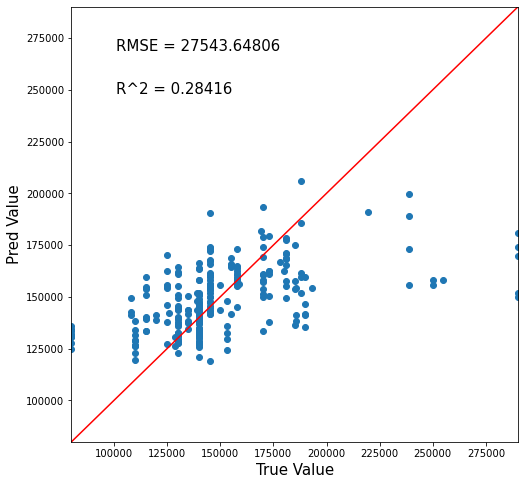

In [30]:
True_Pred_map(valid_predicted_df)

### lightgbm エラー　警告集
#### エラー

#### 警告
LightGBM UserWarning: Using categorical_feature in Dataset
→categorical_features = のオプションはつけず、Datasetsの型変換でcategoryにする
https://qiita.com/junkoda/items/ddf35a240e9aa3f0d9f6

In [31]:
# run all 止めるよう
aaaabbbb

NameError: name 'aaaabbbb' is not defined

# パラメータを自動調整？？？

from optuna.integration import lightgbm as lgb

# KFoldでtrainとvalidに分割
ss = StratifiedKFold(n_splits = 10, shuffle = True)
train_index, valid_index = next(ss.split(train_x,train_y))
X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
y_train, y_valid = train_y[train_index], train_y[valid_index]

# lightgbmで学習
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

# ハイパーパラメータの設定
params = {'metric' : 'rmse'}

# 訓練データから回帰モデルを作る
gbm = lgb.train(params, train_data,valid_sets = valid_data, early_stopping_rounds=100)

# validで予測精度を確認
test_predicted = gbm.predict(X_valid)
predicted_df = pd.concat([y_valid.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
predicted_df.columns = ['true', 'predicted']


print('\nRMSE',np.sqrt(mean_squared_error(predicted_df['true'],predicted_df['predicted'])))
#print('決定係数',r2_score(predicted_df['true'],predicted_df['predicted']))

In [ ]:
!pip install optuna
from optuna.integration import lightgbm as lgb


In [ ]:
#lgb.Dataset(train_x)
#gbm.train(params,train_x)


# データを提出できる形に

In [ ]:
df_submit_predicted = pd.DataFrame(preds_mean)

df_submit = pd.concat([test_index,df_submit_predicted],axis = 1)
df_submit.to_csv('submit_maeshori.csv',index = None, header = None)

In [ ]:
test_index

In [ ]:
master_train_x